In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import math

import matplotlib.pyplot as plt

In [2]:
# ==== CONFIG ====
csv_path = "sbc_counter_result.csv"

n_past = 24                   # số bước thời gian dùng làm input
target_counters = [6, 9]   # các counter_id cần DỰ ĐOÁN (n_counter)

# ==== LOAD & PIVOT ====
df = pd.read_csv(csv_path)

# bỏ cột không dùng
df = df.drop(columns=['id', 'counter_option'])

# chuẩn hóa thời gian
df['trigger_time'] = pd.to_datetime(df['trigger_time'], unit='s')
df = df.sort_values('trigger_time')

# === pivot TẤT CẢ counter làm feature ===
# index = time, columns = (node_id, counter_id), value = counter_value
df_pivot = df.pivot_table(
    index='trigger_time',
    columns=['node_id', 'counter_id'],
    values='counter_value'
)

df_pivot = df_pivot.sort_index(axis=1)   # sắp xếp cột theo (node_id, counter_id)

print("df_pivot shape:", df_pivot.shape)     # (n_time, n_nodes * n_all_counters)
print("Một vài cột:", df_pivot.columns[:10])
df_pivot.head()

df_pivot shape: (26209, 120)
Một vài cột: MultiIndex([(1,  1),
            (1,  2),
            (1,  3),
            (1,  4),
            (1,  5),
            (1,  6),
            (1,  7),
            (1,  8),
            (1,  9),
            (1, 10)],
           names=['node_id', 'counter_id'])


node_id                    1                                               \
counter_id                1        2        3        4        5        6    
trigger_time                                                                
2025-09-07 18:39:27  22695.0  20238.0  20681.0  19287.0  22703.0  18683.0   
2025-09-07 18:44:27  21120.0  19911.0  21249.0  21861.0  18355.0  20104.0   
2025-09-07 18:49:27  19024.0  20255.0  19361.0  21907.0  18896.0  19823.0   
2025-09-07 18:54:27  19199.0  23258.0  20103.0  19764.0  18378.0  19695.0   
2025-09-07 18:59:27  20564.0  22984.0  17187.0  19524.0  21141.0  20346.0   

node_id                                                  ...        6  \
counter_id                7        8        9        10  ...       11   
trigger_time                                             ...            
2025-09-07 18:39:27  19338.0  19689.0  17477.0  18901.0  ...  23816.0   
2025-09-07 18:44:27  22204.0  20710.0  19171.0  21094.0  ...  20085.0   
2025-09-07 18:49:27  19579.0  18229.0  21886.0  19680.0  ...  20821.0   
2025-09-07 18:54:27  18769.0  19945.0  20138.0  18877.0  ...  17981.0   
2025-09-07 18:59:27  18875.0  20374.0  20394.0  17472.0  ...  19279.0   

node_id                                                                    \
counter_id                12       13       14       15       16       17   
trigger_time                                                                
2025-09-07 18:39:27  18616.0  19922.0  20057.0  18213.0  18327.0  17304.0   
2025-09-07 18:44:27  18478.0  21396.0  21944.0  20388.0  18512.0  20991.0   
2025-09-07 18:49:27  19749.0  17640.0  22354.0  21744.0  16455.0  18865.0   
2025-09-07 18:54:27  19731.0  18713.0  19907.0  21435.0  18740.0  21203.0   
2025-09-07 18:59:27  19909.0  21264.0  20723.0  19466.0  23496.0  24569.0   

node_id                                         
counter_id                18       19       20  
trigger_time                                    
2025-09-07 18:39:27  19542.0  21080.0  22515.0  
2025-09-07 18:44:27  19283.0  18880.0  18020.0  
2025-09-07 18:49:27  19036.0  20220.0  17023.0  
2025-09-07 18:54:27  20388.0  21997.0  20412.0  
2025-09-07 18:59:27  19481.0  19262.0  20204.0  

[5 rows x 120 columns]

In [3]:
# Tính tổng theo từng counter_id trên tất cả node
# sum_by_counter = df_pivot.groupby(level='counter_id', axis=1).sum()

# Các counter có tổng == 0 ở mọi thời điểm ⇒ toàn 0
# zero_counters = sum_by_counter.columns[(sum_by_counter == 0).all()]
# print("Counter_id toàn 0:", list(zero_counters))

# Xoá toàn bộ các cột có counter_id nằm trong zero_counters
# df_pivot = df_pivot.drop(columns=zero_counters, level='counter_id')

# print("df_pivot_clean shape:", df_pivot.shape)
# print("Các cột còn lại:", df_pivot.columns.tolist())
# print("\n=== df_pivot sau khi xoá counter toàn 0 ===")
# df_pivot

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_pivot.values)

n_time, n_features_all = data_scaled.shape
node_ids = df_pivot.columns.get_level_values(0).unique()
all_counters = df_pivot.columns.get_level_values(1).unique()

n_nodes = len(node_ids)
n_all_counters = len(all_counters)

print("n_time:", n_time)
print("n_features_all:", n_features_all)
print("n_nodes:", n_nodes, "n_all_counters:", n_all_counters)
print("node_ids: ", node_ids)

n_time: 26209
n_features_all: 120
n_nodes: 6 n_all_counters: 20
node_ids:  Index([1, 2, 3, 4, 5, 6], dtype='int64', name='node_id')


In [5]:
# Lấy MultiIndex columns
cols = df_pivot.columns  # MultiIndex (node_id, counter_id)

# Tìm index các cột có counter_id thuộc target_counters
target_col_indices = [
    i for i, (nid, cid) in enumerate(zip(cols.get_level_values(0), cols.get_level_values(1)))
    if cid in target_counters
]
print(target_col_indices)

print("Số cột target:", len(target_col_indices))
# n_target_features = n_nodes * n_target_counters
n_target_counters = len(target_counters)
assert len(target_col_indices) == n_nodes * n_target_counters

[5, 8, 25, 28, 45, 48, 65, 68, 85, 88, 105, 108]
Số cột target: 12


In [6]:
def create_xy_all_features_target_subset(
    data_scaled,
    n_past,
    target_col_indices,
    n_nodes,
    n_target_counters
):
    X, Y = [], []
    n_time, n_features_all = data_scaled.shape

    for i in range(n_past, n_time):
        # input: n_past bước trước
        X.append(data_scaled[i - n_past:i, :])  # (n_past, n_features_all)

        # output: time step hiện tại, chỉ lấy các cột target
        y_vec = data_scaled[i, target_col_indices]  # (n_nodes * n_target_counters,)
        Y.append(y_vec)

    X = np.array(X)
    Y = np.array(Y)

    # reshape Y về (N, n_nodes, n_target_counters)
    Y = Y.reshape(-1, n_nodes, n_target_counters)

    return X, Y

X, Y = create_xy_all_features_target_subset(
    data_scaled,
    n_past,
    target_col_indices,
    n_nodes,
    n_target_counters
)

print("X:", X.shape)  # (N, n_past, n_features_all)
print("Y:", Y.shape)  # (N, n_nodes, n_target_counters)

X: (26185, 24, 120)
Y: (26185, 6, 2)


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=False
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("Y_train:", Y_train.shape, "Y_test:", Y_test.shape)

n_past = X_train.shape[1]
n_features_all = X_train.shape[2]

X_train: (20948, 24, 120) X_test: (5237, 24, 120)
Y_train: (20948, 6, 2) Y_test: (5237, 6, 2)


In [8]:
# ===== PYTORCH SETUP =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Chuyển numpy -> torch tensor
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)

X_test_t  = torch.tensor(X_test, dtype=torch.float32)
Y_test_t  = torch.tensor(Y_test, dtype=torch.float32)

# DataLoader
train_dataset = TensorDataset(X_train_t, Y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Using device: cuda


In [9]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # tạo ma trận (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) *
                             (-math.log(10000.0) / d_model))
        # Even indices: sin
        pe[:, 0::2] = torch.sin(position * div_term)
        # Odd indices: cos
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        # đăng ký buffer để không tính là tham số train
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: (batch, seq_len, d_model)
        """
        seq_len = x.size(1)
        # cộng PE tương ứng với từng time step
        x = x + self.pe[:, :seq_len, :]
        return x

In [10]:
class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        n_past,
        n_features_all,
        n_nodes,
        n_target_counters,
        d_model=128,
        nhead=4,
        num_layers=2,
        dim_feedforward=256,
        dropout=0.1
    ):
        """
        n_past            : số time steps (seq_len)
        n_features_all    : số feature tại mỗi time step (tất cả (node, counter))
        n_nodes           : số node
        n_target_counters : số counter cần dự đoán
        d_model           : kích thước ẩn trong Transformer
        """
        super().__init__()
        self.n_past = n_past
        self.n_features_all = n_features_all
        self.n_nodes = n_nodes
        self.n_target_counters = n_target_counters
        self.d_model = d_model

        # Chiếu feature gốc -> d_model
        self.input_proj = nn.Linear(n_features_all, d_model)

        # Positional encoding (sinusoidal)
        self.pos_encoder = SinusoidalPositionalEncoding(d_model=d_model, max_len=n_past)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # cho phép input (batch, seq, feature)
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # "Readout" MLP sau khi pooling
        self.fc1 = nn.Linear(d_model, 128)
        self.dropout = nn.Dropout(dropout)

        # Dense ra tất cả node * target counters
        self.fc_out = nn.Linear(128, n_nodes * n_target_counters)

    def forward(self, x):
        """
        x: (batch, n_past, n_features_all)
        return: (batch, n_nodes, n_target_counters)
        """
        # 1) Chiếu lên d_model
        # x: (B, T, F) -> (B, T, d_model)
        x = self.input_proj(x)

        # 2) Thêm positional encoding
        x = self.pos_encoder(x)  # (B, T, d_model)

        # 3) Qua Transformer encoder
        x = self.transformer_encoder(x)  # (B, T, d_model)

        # 4) Pooling theo thời gian (GlobalAveragePooling1D)
        # lấy trung bình các time steps
        x = x.mean(dim=1)  # (B, d_model)

        # 5) Readout MLP
        x = self.fc1(x)         # (B, 128)
        x = torch.relu(x)
        x = self.dropout(x)

        # 6) Dense ra (n_nodes * n_target_counters)
        x = self.fc_out(x)      # (B, n_nodes * n_target_counters)

        # 7) Reshape -> (B, n_nodes, n_target_counters)
        x = x.view(-1, self.n_nodes, self.n_target_counters)

        return x


In [11]:
model = TimeSeriesTransformer(
    n_past=n_past,
    n_features_all=n_features_all,
    n_nodes=n_nodes,
    n_target_counters=n_target_counters,
    d_model=128,
    nhead=4,
    num_layers=2,
    dim_feedforward=256,
    dropout=0.1
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
model.train()
for epoch in range(20):
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)  # (B, n_past, n_features_all)
        yb = yb.to(device)  # (B, n_nodes, n_target_counters)

        optimizer.zero_grad()
        preds = model(xb)   # (B, n_nodes, n_target_counters)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * xb.size(0)

    epoch_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}: loss = {epoch_loss:.6f}")

Epoch 1: loss = 0.009672
Epoch 2: loss = 0.007537
Epoch 3: loss = 0.007130
Epoch 4: loss = 0.007124
Epoch 5: loss = 0.007055
Epoch 6: loss = 0.007026
Epoch 7: loss = 0.006958
Epoch 8: loss = 0.006964
Epoch 9: loss = 0.006921
Epoch 10: loss = 0.006936
Epoch 11: loss = 0.006957
Epoch 12: loss = 0.006895
Epoch 13: loss = 0.006877
Epoch 14: loss = 0.006894
Epoch 15: loss = 0.006885
Epoch 16: loss = 0.006938
Epoch 17: loss = 0.006919
Epoch 18: loss = 0.006971
Epoch 19: loss = 0.006837
Epoch 20: loss = 0.006972


In [13]:
model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_pred_t = model(X_test_t)    # (N_test, n_nodes, n_target_counters)
    Y_pred_scaled = Y_pred_t.cpu().numpy()

In [14]:
# 1. Dự đoán (đang ở scale)
# Y_pred_scaled = model.predict(X_test)  # (N_test, n_nodes, n_target_counters)  <-- BỎ DÒNG NÀY

# Thay bằng Y_pred_scaled từ PyTorch
# Y_pred_scaled đã có ở trên

# Flatten (N_test, n_nodes * n_target_counters)
N_test = Y_test.shape[0]
Y_test_scaled_flat = Y_test.reshape(N_test, n_nodes * n_target_counters)
Y_pred_scaled_flat = Y_pred_scaled.reshape(N_test, n_nodes * n_target_counters)

# 2. Tạo mảng tạm full feature
temp_true = np.zeros((N_test, n_features_all))
temp_pred = np.zeros((N_test, n_features_all))

# 3. Gán các cột target vào đúng vị trí
temp_true[:, target_col_indices] = Y_test_scaled_flat
temp_pred[:, target_col_indices] = Y_pred_scaled_flat

# 4. inverse_transform cho toàn bộ rồi lấy lại phần cần
temp_true_inv = scaler.inverse_transform(temp_true)
temp_pred_inv = scaler.inverse_transform(temp_pred)

Y_test_inv_flat = temp_true_inv[:, target_col_indices]
Y_pred_inv_flat = temp_pred_inv[:, target_col_indices]

# 5. reshape lại (N_test, n_nodes, n_target_counters)
Y_test_inv = Y_test_inv_flat.reshape(N_test, n_nodes, n_target_counters)
Y_pred_inv = Y_pred_inv_flat.reshape(N_test, n_nodes, n_target_counters)


In [15]:
# Hàm đánh giá chi tiết từng node × counter
def evaluate_per_node_counter(Y_test, Y_pred_scaled, target_counters, node_ids):
    """
    Tính MAE, RMSE cho từng (node_id, counter_id).
    """
    N_test, n_nodes, n_counters = Y_test.shape

    results = []

    for i in range(n_nodes):
        for j in range(n_counters):
            actual = Y_test[:, i, j]
            pred   = Y_pred_scaled[:, i, j]

            mae  = mean_absolute_error(actual, pred)
            rmse = np.sqrt(mean_squared_error(actual, pred))

            results.append({
                "node_id": node_ids[i],
                "counter_id": target_counters[j],
                "MAE": mae,
                "RMSE": rmse
            })

    return results

    
results_node_counter = evaluate_per_node_counter(
    Y_test, Y_pred_scaled, target_counters, node_ids
)

df_eval = pd.DataFrame(results_node_counter)
df_eval

,node_id,counter_id,MAE,RMSE
0,1,6,0.055165,0.082409
1,1,9,0.055866,0.082766
2,2,6,0.056592,0.082398
3,2,9,0.054544,0.080727
4,3,6,0.054754,0.081985
5,3,9,0.055308,0.083162
6,4,6,0.054570,0.081413
7,4,9,0.055157,0.081646
8,5,6,0.055007,0.081544
9,5,9,0.055478,0.082037


In [16]:
# Hàm đánh giá theo từng counter
def evaluate_per_counter(Y_test, Y_pred_scaled, target_counters):
    """
    MAE/RMSE cho từng counter_id (toàn bộ node).
    """
    N_test, n_nodes, n_counters = Y_test.shape

    results = []

    for j in range(n_counters):
        actual = Y_test[:, :, j].reshape(-1)   # flatten toàn bộ node
        pred   = Y_pred_scaled[:, :, j].reshape(-1)

        mae  = mean_absolute_error(actual, pred)
        rmse = np.sqrt(mean_squared_error(actual, pred))

        results.append({
            "counter_id": target_counters[j],
            "MAE": mae,
            "RMSE": rmse
        })

    return results

df_counter = pd.DataFrame(evaluate_per_counter(Y_test, Y_pred_scaled, target_counters))
df_counter

,counter_id,MAE,RMSE
0,6,0.055490,0.082132
1,9,0.055252,0.082066


In [17]:
# Hàm đánh giá toàn mô hình
def evaluate_overall(Y_test, Y_pred_scaled):
    """
    MAE / RMSE toàn mô hình (mọi node + mọi counter).
    """
    actual = Y_test.reshape(-1)
    pred   = Y_pred_scaled.reshape(-1)

    mae  = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))

    return {"MAE": mae, "RMSE": rmse}

overall = evaluate_overall(Y_test, Y_pred_scaled)
overall

{'MAE': 0.055370793039632916, 'RMSE': 0.0820990182460922}

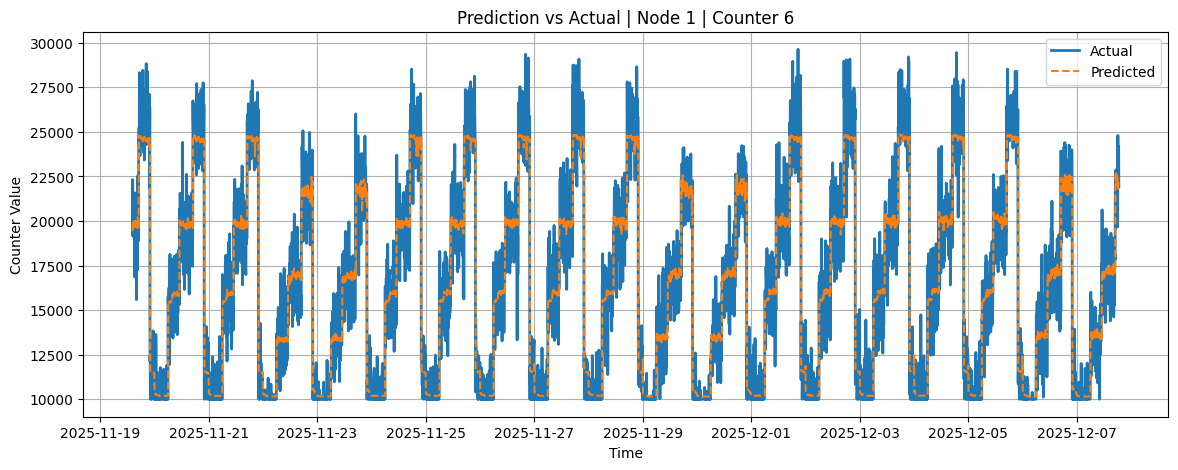

In [18]:
def plot_single_node_counter(
    time_index_test,
    Y_test_inv, 
    Y_pred_inv,
    node_idx,            # index node (0..n_nodes-1)
    counter_idx,         # index counter trong target_counters (0..n_target_counters-1)
    target_counters,
    node_ids,
    title_prefix="Prediction vs Actual"
):
    """
    Vẽ biểu đồ đường cho 1 node và 1 counter.
    """
    actual = Y_test_inv[:, node_idx, counter_idx]
    pred   = Y_pred_inv[:, node_idx, counter_idx]

    counter_id = target_counters[counter_idx]
    node_id    = node_ids[node_idx]

    plt.figure(figsize=(14,5))
    plt.plot(time_index_test, actual, label="Actual", linewidth=2)
    plt.plot(time_index_test, pred, label="Predicted", linestyle="--")
    
    plt.title(f"{title_prefix} | Node {node_id} | Counter {counter_id}")
    plt.xlabel("Time")
    plt.ylabel("Counter Value")
    plt.grid(True)
    plt.legend()
    plt.show()

time_index = df_pivot.index[n_past:]       # thời gian tương ứng với X,Y
time_index_train = time_index[:len(X_train)]
time_index_test  = time_index[len(X_train):]

plot_single_node_counter(
    time_index_test,
    Y_test_inv,
    Y_pred_inv,
    node_idx=0,
    counter_idx=0,
    target_counters=target_counters,
    node_ids=node_ids
)

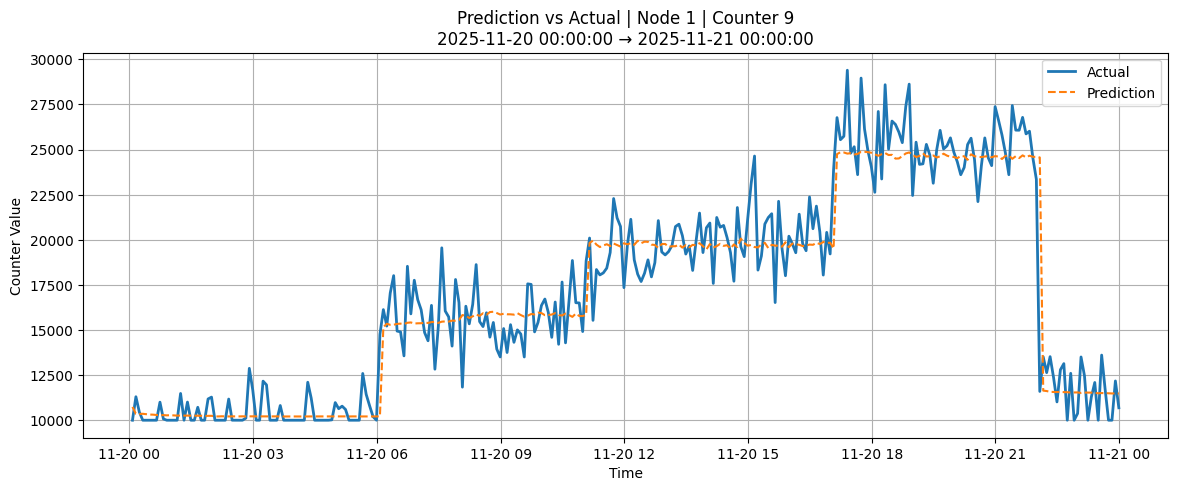

In [19]:
def plot_single_node_counter_timerange(
    time_index_test,
    Y_test_inv,
    Y_pred_inv,
    node_idx,
    counter_idx,
    target_counters,
    node_ids,
    start_time,
    end_time,
    title_prefix="Prediction vs Actual"
):
    """
    Vẽ biểu đồ đường cho 1 node và 1 counter trong khoảng thời gian chỉ định.
    
    start_time, end_time: dạng string '2025-01-01 00:00:00' hoặc datetime
    """

    # Convert thời gian nếu cần
    if isinstance(start_time, str):
        start_time = pd.to_datetime(start_time)
    if isinstance(end_time, str):
        end_time = pd.to_datetime(end_time)

    # --- Tìm index trong đoạn thời gian X -> Y ---
    mask = (time_index_test >= start_time) & (time_index_test <= end_time)

    if mask.sum() == 0:
        print("❌ Không có dữ liệu trong khoảng thời gian yêu cầu!")
        return

    t = time_index_test[mask]
    actual = Y_test_inv[mask, node_idx, counter_idx]
    pred   = Y_pred_inv[mask, node_idx, counter_idx]

    counter_id = target_counters[counter_idx]
    node_id = node_ids[node_idx]

    # --- Vẽ ---
    plt.figure(figsize=(14, 5))
    plt.plot(t, actual, label="Actual", linewidth=2)
    plt.plot(t, pred, label="Prediction", linestyle="--")

    plt.title(f"{title_prefix} | Node {node_id} | Counter {counter_id}\n{start_time} → {end_time}")
    plt.xlabel("Time")
    plt.ylabel("Counter Value")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_single_node_counter_timerange(
    time_index_test,
    Y_test_inv,
    Y_pred_inv,
    node_idx=0,
    counter_idx=1,
    target_counters=target_counters,
    node_ids=node_ids,
    start_time="2025-11-20 00:00:00",
    end_time="2025-11-21 00:00:00"
)

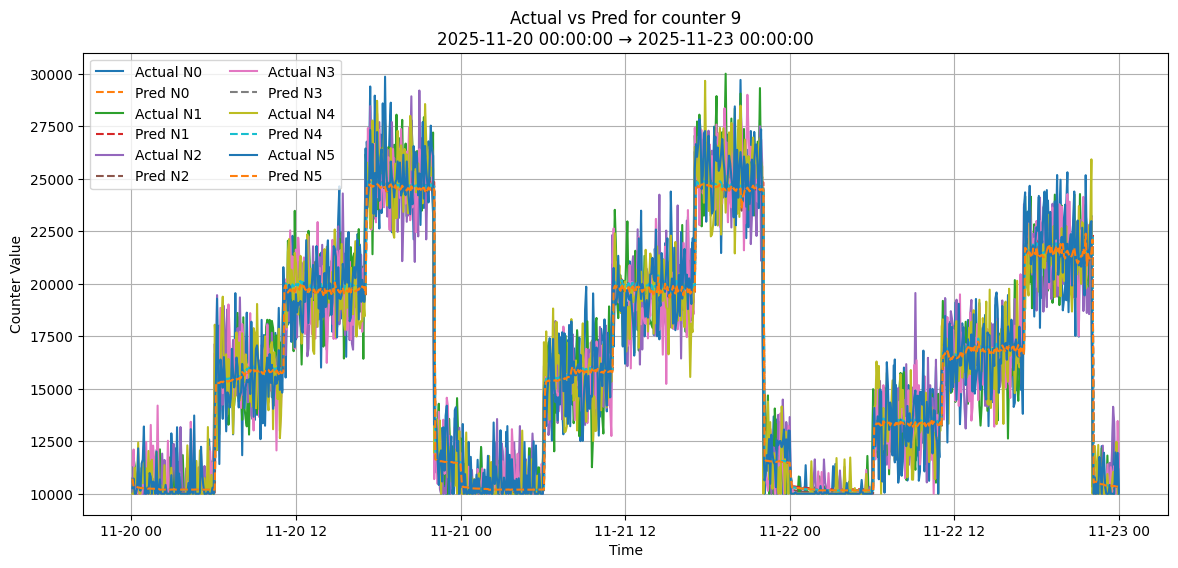

In [20]:
def plot_all_nodes_timerange(
    time_index_test,
    Y_test_inv,
    Y_pred_inv,
    counter_idx,
    target_counters,
    node_ids,
    start_time,
    end_time
):
    if isinstance(start_time, str):
        start_time = pd.to_datetime(start_time)
    if isinstance(end_time, str):
        end_time = pd.to_datetime(end_time)

    mask = (time_index_test >= start_time) & (time_index_test <= end_time)

    if mask.sum() == 0:
        print("❌ Không có dữ liệu trong khoảng thời gian yêu cầu!")
        return

    t = time_index_test[mask]
    n_nodes = Y_test_inv.shape[1]

    plt.figure(figsize=(14, 6))

    for i in range(n_nodes):
        plt.plot(t, Y_test_inv[mask, i, counter_idx], label=f"Actual N{i}")
        plt.plot(t, Y_pred_inv[mask, i, counter_idx], linestyle="--", label=f"Pred N{i}")

    counter_id = target_counters[counter_idx]

    plt.title(f"Actual vs Pred for counter {counter_id}\n{start_time} → {end_time}")
    plt.xlabel("Time")
    plt.ylabel("Counter Value")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.show()

plot_all_nodes_timerange(
    time_index_test,
    Y_test_inv,
    Y_pred_inv,
    counter_idx=1,
    target_counters=target_counters,
    node_ids=node_ids,
    start_time="2025-11-20 00:00:00",
    end_time="2025-11-23 00:00:00"
)

In [21]:
def evaluate_weekday_vs_weekend(Y_test, Y_pred, time_index_test):
    """
    Đánh giá MAE, RMSE giữa ngày trong tuần (Mon-Fri) và cuối tuần (Sat-Sun).
    
    Y_test_inv, Y_pred_inv: (N_test, n_nodes, n_target_counters)
    time_index_test: DatetimeIndex hoặc Series có length = N_test
    """
    # Đảm bảo time_index_test là DatetimeIndex
    time_index_test = pd.to_datetime(time_index_test)
    
    # Tạo mask
    weekday_mask = time_index_test.weekday < 5    # 0..4: Mon-Fri
    weekend_mask = time_index_test.weekday >= 5   # 5..6: Sat-Sun
    
    results = {}
    
    def _calc_metrics(mask, name):
        if mask.sum() == 0:
            return {f"{name}_MAE": np.nan, f"{name}_RMSE": np.nan}
        
        actual = Y_test[mask].reshape(-1)
        pred   = Y_pred[mask].reshape(-1)
        
        mae  = mean_absolute_error(actual, pred)
        rmse = np.sqrt(mean_squared_error(actual, pred))
        return {f"{name}_MAE": mae, f"{name}_RMSE": rmse}
    
    results.update(_calc_metrics(weekday_mask, "weekday"))
    results.update(_calc_metrics(weekend_mask, "weekend"))
    
    return results

weekday_weekend_metrics = evaluate_weekday_vs_weekend(
    Y_test, Y_pred_scaled, time_index_test
)
print(weekday_weekend_metrics)

{'weekday_MAE': 0.05834874891102921, 'weekday_RMSE': 0.08572944722459282, 'weekend_MAE': 0.04897642024606381, 'weekend_RMSE': 0.07370183907371514}


In [22]:
# Hàm đánh giá theo từng giờ trong ngày
def evaluate_by_hour_of_day(Y_test, Y_pred, time_index_test):
    """
    Đánh giá MAE, RMSE cho từng giờ trong ngày (0-23).
    
    Returns: list[dict] để dễ chuyển thành DataFrame.
    """
    time_index_test = pd.to_datetime(time_index_test)
    hours = time_index_test.hour.values  # array (N_test,)
    
    results = []
    
    for h in range(24):
        mask = (hours == h)
        if mask.sum() == 0:
            # Không có mẫu nào ở giờ này
            results.append({
                "hour": h,
                "MAE": np.nan,
                "RMSE": np.nan,
                "n_samples": 0
            })
            continue
        
        actual = Y_test[mask].reshape(-1)
        pred   = Y_pred[mask].reshape(-1)
        
        mae  = mean_absolute_error(actual, pred)
        rmse = np.sqrt(mean_squared_error(actual, pred))
        
        results.append({
            "hour": h,
            "MAE": mae,
            "RMSE": rmse,
            "n_samples": mask.sum()
        })
    
    return results

hour_metrics = evaluate_by_hour_of_day(Y_test, Y_pred_scaled, time_index_test)

import pandas as pd
df_hour_metrics = pd.DataFrame(hour_metrics)
print(df_hour_metrics)

    hour       MAE      RMSE  n_samples
0      0  0.024650  0.038063        216
1      1  0.021468  0.035120        216
2      2  0.020916  0.036484        216
3      3  0.020200  0.034774        216
4      4  0.021482  0.036942        216
5      5  0.021422  0.037104        216
6      6  0.076233  0.104079        216
7      7  0.060995  0.076395        216
8      8  0.060751  0.076168        216
9      9  0.059240  0.074570        216
10    10  0.061618  0.076618        216
11    11  0.071572  0.092443        216
12    12  0.061262  0.076984        216
13    13  0.061622  0.077745        216
14    14  0.060280  0.075561        225
15    15  0.062217  0.077560        228
16    16  0.060225  0.076426        228
17    17  0.082505  0.112651        228
18    18  0.066780  0.082894        224
19    19  0.067165  0.083997        216
20    20  0.067567  0.084209        216
21    21  0.067990  0.084576        216
22    22  0.097502  0.191202        216
23    23  0.050455  0.064780        216


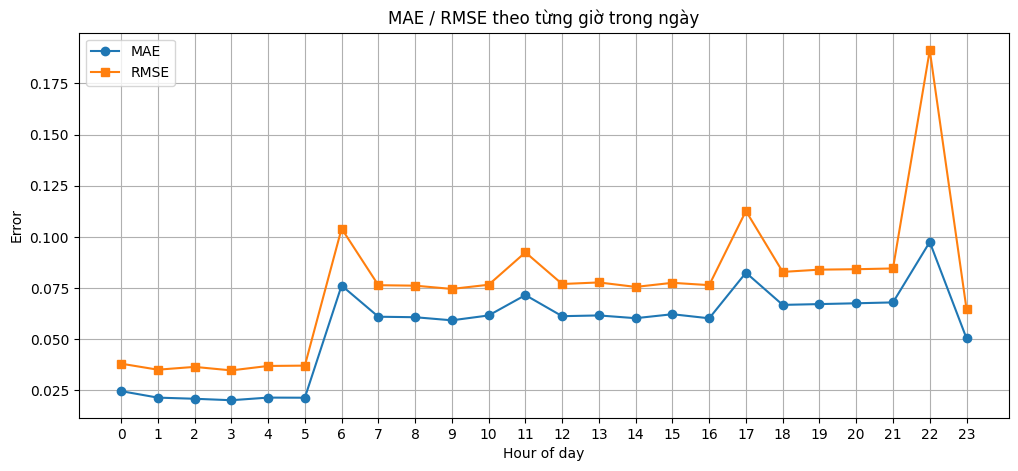

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_hour_metrics["hour"], df_hour_metrics["MAE"], marker="o", label="MAE")
plt.plot(df_hour_metrics["hour"], df_hour_metrics["RMSE"], marker="s", label="RMSE")
plt.xlabel("Hour of day")
plt.ylabel("Error")
plt.title("MAE / RMSE theo từng giờ trong ngày")
plt.grid(True)
plt.legend()
plt.xticks(range(0, 24))
plt.show()

In [24]:
# === SAVE MODEL ===
# torch.save(model.state_dict(), "lstm_forecast_model.pth")
# print("✅ Model saved.")